# Projeto - Mineração de Texto e Web
## Residência Engenharia e Ciência de dados - Samsung/UFPE

### Lucas Couri - lncc2
### Mariama Oliveira - mcso

## Carregando Dados

In [1]:
#Imports
import string
import nltk
from nltk.corpus import stopwords
import pandas as pd
# from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.sparse import csr_matrix
from scipy.cluster.vq import vq

import numpy as np
import tensorflow as tf
#from keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv2D, Input
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

import dataset_split 
import networks



In [2]:
df = pd.read_csv("reviews_v2.csv")
df = df[df["reviews"].notna()]

## Pré-processamento (com e sem stemming)

In [3]:
#Global variables
other_punctuation = '—“”'  
stop_words = stopwords.words('portuguese')
stop_words.append('’')
stemmer = nltk.stem.RSLPStemmer()


#Function that removes punctuation 
def remove_punctuation(text):
    punctuation_free_doc = "".join([i for i in text if i not in string.punctuation+other_punctuation])
    return punctuation_free_doc


def remove_stopwords(list_words):
    filtered_words = [word for word in list_words if word not in stop_words]
    return filtered_words


def do_stemming(list_words):
    stem_text = [stemmer.stem(word) for word in list_words]
    return stem_text


def pre_process(doc, basic_processing = False, no_stopwords = False, stemming = False):

    final_doc = doc
    
    ## print(final_doc)

    if basic_processing == True:
        
        final_doc = remove_punctuation(doc)
        final_doc = final_doc.lower()

    final_doc = nltk.word_tokenize(final_doc)

    if no_stopwords == True:
        final_doc = remove_stopwords(final_doc)    

    if stemming == True:
        final_doc = do_stemming(final_doc)

    return final_doc

def pre_process_all(df, pre_processing_list):

    for param, index in zip(pre_processing_list, range(len(pre_processing_list))):
        
        df[f"reviews_pipeline_{index}"] = df["reviews"].apply(lambda x: pre_process(x, **param))

    return df

pre_processing_list = [
    {"basic_processing": True, "no_stopwords": True, "stemming": False},
    {"basic_processing": True, "no_stopwords": True, "stemming": True}]

df_pp = pre_process_all(df, pre_processing_list)

## Definindo classe

In [4]:
df_pp["class"] = df_pp["stars"].apply(lambda x : 1 if x >=4 else 0)

## Divisão Train, Validation e Test

In [5]:
#Unbalanced dataset
X_train, X_valid, X_test, y_train, y_valid, y_test = dataset_split.split_data(df_pp)

#Balanced dataset
X_train_b, X_valid_b, X_test_b, y_train_b, y_valid_b, y_test_b = dataset_split.split_data(df_pp, True)

Transformando tokens em string

In [6]:
def tokens_to_string(df):
    X_train_join = []
    X_train_join.append(df["reviews_pipeline_0"].apply(" ".join))
    X_train_join.append(df["reviews_pipeline_1"].apply(" ".join))
    X_train_join[0] = X_train_join[0].to_numpy()
    X_train_join[1] = X_train_join[1].to_numpy()

    return X_train_join

In [7]:
#Unbalanced data
X_train_join = tokens_to_string(X_train)
X_test_join = tokens_to_string(X_test)
X_valid_join = tokens_to_string(X_valid)

#Balanced data
X_train_join_b = tokens_to_string(X_train_b)
X_test_join_b = tokens_to_string(X_test_b)
X_valid_join_b = tokens_to_string(X_valid_b)


# Classificadores 

## Random Forest com BoW

In [ ]:
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 2000) 

#List with BoWs (pipeline 0 and 1)
X_train_vec = []
X_train_vec.append(vectorizer.fit_transform(X_train_valid_join[0]))
X_train_vec.append(vectorizer.fit_transform(X_train_valid_join[1]))

X_test_vec = []
X_test_vec.append(vectorizer.fit_transform(X_test_join[0]))
X_test_vec.append(vectorizer.fit_transform(X_test_join[1]))

# X_valid_vec = []
# X_valid_vec.append(vectorizer.fit_transform(X_valid_join[0]))
# X_valid_vec.append(vectorizer.fit_transform(X_valid_join[1]))


print(X_train_vec[0].shape)

### Sem stemming

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

cv = model_selection.StratifiedKFold(n_splits=10)

In [ ]:
import optuna
import sklearn
from sklearn import datasets
def objective(trial):
      iris = sklearn.datasets.load_iris()
      n_estimators = trial.suggest_int('n_estimators', 2, 20)
      max_depth = int(trial.suggest_loguniform('max_depth', 1, 32))
      clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
      return sklearn.model_selection.cross_val_score(clf, iris.data, iris.target, 
           n_jobs=-1, cv=3).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [ ]:
def val_rf(X_train, y_train, parameters, cv, SEED):

    rf = RandomForestClassifier(random_state = SEED)

    search = GridSearchCV(rf,
                          parameters,
                          scoring = "accuracy",
                          n_jobs = -1,
                          cv = cv)

    result_rf = search.fit(X_train, y_train)
    
    print('=========Resultados do Grid Search para Random Forest==========')
    print(f'Melhor Score: {result_rf.best_score_}')
    print(f'Melhores Hiperparâmetros: {result_rf.best_params_}')

    return result_rf

parameters = dict()
parameters['n_estimators'] = range(10, 101, 10)
parameters['criterion'] = ["gini", "entropy"]
#parameters['max_features'] = ["auto", "sqrt", "log2"]
#parameters['min_samples_leaf'] = [1, 4]
#parameters['min_samples_split'] = [2, 10]
#parameters['max_depth'] = [10, 100, None]#[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]

result_rf_0 = val_rf(X_train_vec[0], y_train_valid, parameters, cv, 42)

In [ ]:
forest = RandomForestClassifier(**result_rf_0.best_params_) 
forest = forest.fit(X_train_vec[0], y_train_valid)

In [ ]:
predictions = forest.predict(X_test_vec[0]) 
result = forest.predict(X_test_vec[0])
print(classification_report(y_test, result))


Matriz de Confusão

In [ ]:
confusion_matrix(y_test, result)

### Com Stemming

In [ ]:
parameters = dict()
parameters['n_estimators'] = range(10, 101, 10)
parameters['criterion'] = ["gini", "entropy"]
#parameters['max_features'] = ["auto", "sqrt", "log2"]
#parameters['min_samples_leaf'] = [1, 4]
#parameters['min_samples_split'] = [2, 10]
#parameters['max_depth'] = [10, 100, None]#[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]

result_rf_1 = val_rf(X_train_vec[1], y_train_valid, parameters, cv, 42)

In [ ]:
forest = RandomForestClassifier(**result_rf_1.best_params_) 
forest = forest.fit(X_train_vec[1], y_train_valid)

In [ ]:
predictions = forest.predict(X_test_vec[1]) 
result = forest.predict(X_test_vec[1])
print(classification_report(y_test, result))


In [ ]:
confusion_matrix(y_test, result)

## Redes (CNN, LSTM e BERT)

### Encoder

In [9]:
# #With stemming
# encoder_0 = networks.sentence_encoder(X_train_join[0])
# encoder_0_b = networks.sentence_encoder(X_train_join_b[0])

# #Without stemming
# encoder_1 = networks.sentence_encoder(X_train_join[1])
# encoder_1_b = networks.sentence_encoder(X_train_join_b[1])

### CNN

In [ ]:
def pipeline_cnn(encoder,tuner_name,X_train, y_train, X_valid, y_valid, X_test, y_test):
    #Finding best parameters
    tuner = networks.cnn_tuner(encoder, tuner_name)
    best_hp = networks.search_cnn(tuner, X_train_join[0], y_train, X_valid_join[0], y_valid)

    #Loading best model
    model_CNN_0 = networks.get_model(tuner, best_hp)
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    history = model_CNN_0.fit(X_train_join[0], y_train, epochs=50, validation_data = (X_valid_join[0], y_valid), callbacks=[stop_early])

    #Getting test results
    networks.get_test_metrics(model_CNN_0, X_test_join[0], y_test)
    networks.plot_acuracy_loss(history)

In [22]:
def pipeline_cnn_lstm(tuner_name,X_train, y_train, X_valid, y_valid, X_test, y_test):
    encoder = networks.sentence_encoder(X_train)

    #Finding best parameters
    tuner = networks.cnn_tuner(encoder, tuner_name)
    best_hp = networks.search_cnn(tuner, X_train, y_train, X_valid, y_valid)

    #Loading best model
    model = networks.get_model(tuner, best_hp)
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    history = model.fit(X_train, y_train, epochs=50, validation_data = (X_valid, y_valid), callbacks=[stop_early])

    #Getting test results
    networks.get_test_metrics(model, X_test, y_test)
    networks.plot_acuracy_loss(history)

#### Sem stemming

INFO:tensorflow:Reloading Oracle from existing project tuner\cnn_test\oracle.json
INFO:tensorflow:Reloading Tuner from tuner\cnn_test\tuner0.json
Search space summary
Default search space size: 2
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
None
INFO:tensorflow:Oracle triggered exit
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, None)              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          16416     
______________________________________________

C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


77/77 [==============================] - ETA: 0s - loss: 0.3226 - accuracy: 0.8939

C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


77/77 [==============================] - 2s 17ms/step - loss: 0.3226 - accuracy: 0.8939 - val_loss: 0.2667 - val_accuracy: 0.8982
Epoch 2/50
77/77 [==============================] - 1s 9ms/step - loss: 0.1873 - accuracy: 0.9229 - val_loss: 0.2449 - val_accuracy: 0.9144
Epoch 3/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0745 - accuracy: 0.9723 - val_loss: 0.3161 - val_accuracy: 0.9106
Epoch 4/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0297 - accuracy: 0.9902 - val_loss: 0.3439 - val_accuracy: 0.9077
Epoch 5/50
77/77 [==============================] - 1s 11ms/step - loss: 0.0164 - accuracy: 0.9947 - val_loss: 0.4108 - val_accuracy: 0.8963
Epoch 6/50
77/77 [==============================] - 1s 11ms/step - loss: 0.0090 - accuracy: 0.9980 - val_loss: 0.4897 - val_accuracy: 0.9049
Epoch 7/50
47/47 [==============================] - 0s 5ms/step - loss: 0.5571 - accuracy: 0.9014
Test Loss: 0.5571296215057373
Test Accuracy: 0.9013990759849548
    

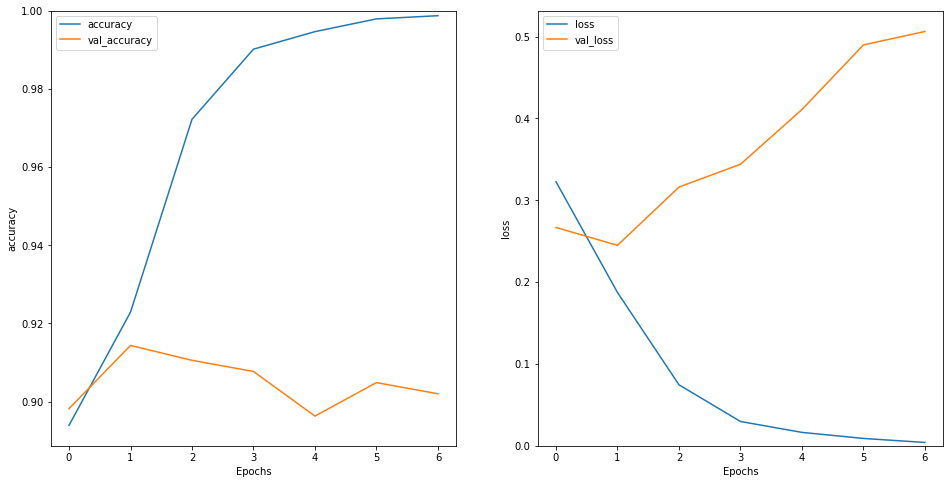

In [23]:
# Desbalanceado
pipeline_cnn_lstm("cnn",X_train_join[0], y_train, X_valid_join[0], y_valid, X_test_join[0], y_test)

Trial 32 Complete [00h 00m 04s]
val_accuracy: 0.8791627287864685

Best val_accuracy So Far: 0.9124643206596375
Total elapsed time: 00h 02m 02s
INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          16416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
globa

C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


91/91 [==============================] - 2s 13ms/step - loss: 0.5340 - accuracy: 0.7501 - val_loss: 0.4151 - val_accuracy: 0.8887
Epoch 2/50
91/91 [==============================] - 1s 10ms/step - loss: 0.3237 - accuracy: 0.8633 - val_loss: 0.2810 - val_accuracy: 0.9096
Epoch 3/50
91/91 [==============================] - 1s 12ms/step - loss: 0.1623 - accuracy: 0.9511 - val_loss: 0.2512 - val_accuracy: 0.9058
Epoch 4/50
91/91 [==============================] - 1s 8ms/step - loss: 0.0988 - accuracy: 0.9728 - val_loss: 0.2529 - val_accuracy: 0.8991
Epoch 5/50
91/91 [==============================] - 1s 8ms/step - loss: 0.0648 - accuracy: 0.9821 - val_loss: 0.2641 - val_accuracy: 0.9001
Epoch 6/50
91/91 [==============================] - 1s 10ms/step - loss: 0.0389 - accuracy: 0.9921 - val_loss: 0.2833 - val_accuracy: 0.9020
Epoch 7/50
91/91 [==============================] - 1s 9ms/step - loss: 0.0240 - accuracy: 0.9966 - val_loss: 0.2997 - val_accuracy: 0.9039
Epoch 8/50
47/47 [=========

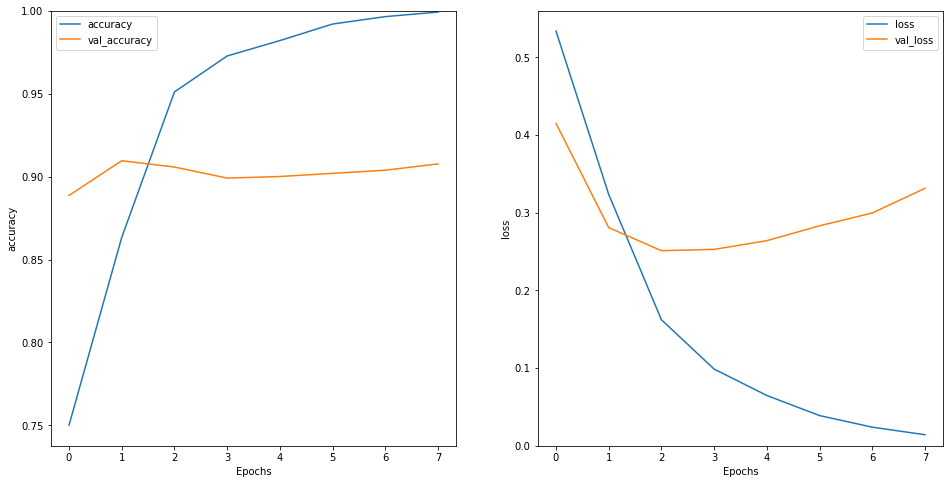

In [25]:
# Balanceado
pipeline_cnn_lstm("cnn_b",X_train_join_b[0], y_train_b, X_valid_join_b[0], y_valid_b, X_test_join_b[0], y_test_b)

#### Com stemming

In [ ]:
#Desbalanceado
pipeline_cnn_lstm("cnn_st",X_train_join[1], y_train, X_valid_join[1], y_valid, X_test_join[1], y_test)

In [ ]:
#Balanceado
pipeline_cnn_lstm("cnn_b_st",X_train_join_b[1], y_train_b, X_valid_join_b[1], y_valid_b, X_test_join_b[1], y_test_b)

### LSTM

In [ ]:
model_LSTM0 = tf.keras.Sequential([
    encoder_0,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_0.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_LSTM0.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
print(model_LSTM0.summary())

#### Sem stemming

Treinando modelo

In [ ]:
history = model_LSTM0.fit(X_train_join[0], y_train, epochs=20,
                    batch_size = 32,
                    validation_data= (X_valid_join[0], y_valid),
                    validation_steps=30
                    )

Avaliando modelo

In [ ]:
test_loss, test_acc = model_LSTM0.evaluate(X_test_join[0], y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
result = model_LSTM0.predict(X_test_join[0])
result = np.where(result > 0.5, 1, 0)
result

print(classification_report(y_test, result))

In [ ]:
confusion_matrix(y_test, result)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

#### Com stemming

In [ ]:
model_LSTM1 = tf.keras.Sequential([
    encoder_1,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_1.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_LSTM1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Treinando modelo

In [ ]:
history = model_LSTM1.fit(X_train_join[1], y_train, epochs=10,
                    batch_size = 32,
                    validation_data= (X_valid_join[1], y_valid),
                    validation_steps=30
                    )

Avaliando modelo

In [ ]:
test_loss, test_acc = model_LSTM1.evaluate(X_test_join[1], y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
result = model_LSTM1.predict(X_test_join[1])
result = np.where(result > 0.5, 1, 0)
result

print(classification_report(y_test, result))

In [ ]:
confusion_matrix(y_test, result)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

### BERT

In [ ]:
from transformers import BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=True)

In [ ]:
def convert_example_to_feature(review):
  return tokenizer.encode_plus(review,
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

In [ ]:
# can be up to 512 for BERT
max_length = 256
batch_size = 1

In [ ]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

In [ ]:
def encode_examples(texts, labels, limit=-1):
  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
  if (limit > 0):
      ds = ds.take(limit)
  # for review, label in tfds.as_numpy(ds):
  for text, label in zip(texts, labels):
    bert_input = convert_example_to_feature(text)
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])
  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

#### Sem stemming

In [ ]:
# train dataset
ds_train_encoded_0 = encode_examples(X_train_join[0], y_train).shuffle(3).batch(batch_size)

# test dataset
ds_test_encoded_0 = encode_examples(X_test_join[0], y_test).batch(batch_size)

#validation dataset
ds_valid_encoded_0 = encode_examples(X_valid_join[0], y_valid).batch(batch_size)

In [ ]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5
# we will do just 1 epoch, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 3
# model initialization
model_bert_0 = TFBertForSequenceClassification.from_pretrained('bert-base-portuguese-cased', from_pt = True)

In [ ]:
# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model_bert_0.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
bert_history = model_bert_0.fit(ds_train_encoded_0, epochs=number_of_epochs, validation_data=ds_valid_encoded_0)

In [ ]:
tf_output = model_bert_0.predict(ds_test_encoded_0)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)
labels = ['Negative','Positive'] #(0:negative, 1:positive)
label = tf.argmax(tf_prediction, axis=1)
label_pred = label.numpy()
print(label_pred)

In [ ]:
unique, counts = np.unique(label_pred, return_counts=True)
dict(zip(unique, counts))

In [ ]:
print(classification_report(y_test, label_pred))

In [ ]:
confusion_matrix(y_test, label_pred)

#### Com stemming

In [ ]:
# train dataset
ds_train_encoded_1 = encode_examples(X_train_join[1], y_train).shuffle(3).batch(batch_size)

# test dataset
ds_test_encoded_1 = encode_examples(X_test_join[1], y_test).batch(batch_size)

#validation dataset
ds_valid_encoded_1 = encode_examples(X_valid_join[1], y_valid).batch(batch_size)

In [ ]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5
# we will do just 1 epoch, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 3
# model initialization
model_bert_1 = TFBertForSequenceClassification.from_pretrained('bert-base-portuguese-cased', from_pt = True)

In [ ]:
# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model_bert_1.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
bert_history = model_bert_1.fit(ds_train_encoded_1, epochs=number_of_epochs, validation_data=ds_valid_encoded_1)

In [ ]:
tf_output = model_bert_1.predict(ds_test_encoded_1)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)
labels = ['Negative','Positive'] #(0:negative, 1:positive)
label = tf.argmax(tf_prediction, axis=1)
label_pred = label.numpy()
print(label_pred)

In [ ]:
unique, counts = np.unique(label_pred, return_counts=True)
dict(zip(unique, counts))

In [ ]:
print(classification_report(y_test, label_pred))

In [ ]:
confusion_matrix(y_test, label_pred)

## Clustering

In [ ]:
df_pp[["reviews", "reviews_pipeline_0", "class"]].head()

In [ ]:
df_cluster = df_pp[["reviews", "reviews_pipeline_0", "class"]]

X_join = df_cluster["reviews_pipeline_0"].apply(" ".join)
X_join = X_join.to_numpy()
#df_cluster["reviews_join"] = X_join

In [ ]:
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 2000) 

#List with BoWs (pipeline 0 and 1)
bow_vec = vectorizer.fit_transform(X_join)

In [ ]:
words = vectorizer.get_feature_names()
#words = vectorizer.get_feature_names_out()

#setup kmeans clustering
kmeans = KMeans(n_clusters = 2, random_state = 420)
#fit the data 
kmeans.fit(bow_vec)

In [ ]:
kmeans.cluster_centers_

https://towardsdatascience.com/k-means-clustering-chardonnay-reviews-using-scikit-learn-nltk-9df3c59527f3

In [ ]:
### Palavras mais comuns em cada cluster
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

Usando distancia

In [ ]:
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, csr_matrix.toarray(bow_vec))
closest

Usando vector quantization (https://stackoverflow.com/questions/21660937/get-nearest-point-to-centroid-scikit-learn)

In [ ]:
# centroids: N-dimensional array with your centroids
# points:    N-dimensional array with your data points
closest, distances = vq(kmeans.cluster_centers_, csr_matrix.toarray(bow_vec))
closest

https://stackoverflow.com/questions/39766593/get-element-closest-to-cluster-centroid

In [ ]:
from scipy.spatial import cKDTree

def find_k_closest(centroids, data, k=1, distance_norm=2):
    """
    Arguments:
    ----------
        centroids: (M, d) ndarray
            M - number of clusters
            d - number of data dimensions
        data: (N, d) ndarray
            N - number of data points
        k: int (default 1)
            nearest neighbour to get
        distance_norm: int (default 2)
            1: Hamming distance (x+y)
            2: Euclidean distance (sqrt(x^2 + y^2))
            np.inf: maximum distance in any dimension (max((x,y)))

    Returns:
    -------
        indices: (M,) ndarray
        values: (M, d) ndarray
    """

    kdtree = cKDTree(data)
    distances, indices = kdtree.query(centroids, k, p=distance_norm)
    if k > 1:
        indices = indices[:,-1]
    values = data[indices]
    return indices, values

indices, values = find_k_closest(kmeans.cluster_centers_, csr_matrix.toarray(bow_vec))

In [ ]:
indices

Achar os n mais proximos (https://stackoverflow.com/questions/26795535/output-50-samples-closest-to-each-cluster-center-using-scikit-learn-k-means-libr)

- n Reviews mais próximas do centróide da classe 0 (Ruim)

In [ ]:
n=3
d = kmeans.transform(csr_matrix.toarray(bow_vec))[:, 0] #distancia de cada ponto ao centroide 0
ind0 = np.argsort(d)[::][:n]
ind0
#csr_matrix.toarray(bow_vec)[ind]

In [ ]:
df_pp.iloc[3650]#["reviews"]

In [ ]:
df_pp.iloc[3650]["reviews"]

In [ ]:
df_pp.iloc[4823]#["reviews"]

In [ ]:
df_pp.iloc[4823]["reviews"]

- n Reviews mais próximas do centróide da classe 1 (Bom)

In [ ]:
n = 3
d = kmeans.transform(csr_matrix.toarray(bow_vec))[:, 1] #distancia de cada ponto ao centroide 1
ind1 = np.argsort(d)[::][:n]
ind1

In [ ]:
df_pp.iloc[3603]#["reviews"]

In [ ]:
df_pp.iloc[3217]#["reviews"]

In [ ]:
df_pp.iloc[3998]#["reviews"]